# 1. Problem Background and Motivation <a class="anchor" id="problem-background"></a>

<img src='' width="700" />

### Problem Description
>- A large chain of international hotels would like to leverage machine learning to be able to accurately predict booking cancellations. Currently, cancellations come in randomly and lead to loss of revenue due to unoccupied rooms.

### Key Stakeholders
>- Hotel Managers - The manager of the hotel can use the data and model output to be able to set up a process that can monetize rooms that are likely to have their bookings cancelled.

>- Cluster Head - Cluster / Region heads of the hotel chain can use the information to be able to set up a wider strategy for their cluster in terms of dealing with cancellations.

# 2. Libraries & Custom Functions <a class="anchor" id="import-packages"></a>

##### Libraries Import:
>- Pandas for data processing and transformation. Numpy for numerical functions
>- Seaborn, Matplotlib for visual representations of data / function outputs
>- (Sklearn) Train_Test_Split to split our data into randomized train and test dataframes.
>- (Sklearn) LogisticRegression to implement a logistic regression model
>- (Sklearn) KNeighborsClassifier to implement a KNN classification model
>- (Sklearn) DecisionTreeClassifier to implement a Decision Tree
>- (Sklearn) MLPClassifier to implement a MLP Classifier
>- (Sklearn) RandomForestClassifier to implement a Random Forest Classifier
>- (Sklearn) Metrics to measure classification performance

##### Custom Functions:
>- Class_Perf_Measures - a function that takes the model object, X_test (which contains the test data predictor variables), Y_test (which contains the test data target variable) to calculate and display performance measures such as recall, precision, and confusion matrix metrics.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

pd.set_option('display.max_columns', None)


# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)
def class_perf_measures(model,X_test,y_test):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    
    # Create list of probability threshold values to loop over
    threshold = np.arange(0,1.1,0.1).tolist()

    # Start loop
    for i in threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,1])
        TN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,0])
        FP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,1])
        FN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,0])
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "Precision":precision,
                           "Recall":recall,
                           "F1":F1,
                           "Accuracy": Accuracy
                          })

    # Let's look at our dataframe
    return result

# Data Source Identification and Access

Here, we connect to the data source that contains the information we need to begin solving this business problem. In this particular case, the data has been provided to us via a CSV file.

In [2]:
df = pd.read_csv("hotel_bookings.csv") # Reading the data

# Exploratory Data Analysis

After storing the data into a dataframe, the first step is to analyze it to understand:

- What does the data represent? 
- What might be the target variable? (If not already specified by the business)
- What steps do we need to take to get the data ready for modeling?
- What are the right features that we need to choose for the purpose of predicting the target variable?

**Steps:**
- [x] Data Exploration
- [x] Data Cleaning
- [x] Data Deep Dive - Numeric (Summary Stats, Outlier Treatment, Feature Transformation, Feature Selection)
- [x] Data Deep Dive - Categorical (Summary Stats, Outlier Treatment, Feature Transformation, Feature Selection)
- [x] Selection of Train & Test Data

><h3>Data Exploration </h3>
First, we load the data and look at a few sample rows (first 5, last 5). We note down any data observations that may require a further deep-dive. Next, we summarize the data to gain more understanding of each column -  we check data types, number of NULLs, and summary statistics (such as mean, median, standard deviation, etc.). We may also try to identify a potential target variable (if not already specified by the business) at this point.

In [3]:
df.tail() #Looking at the last 5 rows of the data, just to get a high level understanding of our data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0
119389,City Hotel,0,205,2017,August,35,29,2,7,2,0.0,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,151.20,0,2


In [4]:
df.info() #Used to understand the data types for each column available in our data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

#### Data types:

- Categorical - hotel, is_canceled, customer_type, is_repeated_guest, meal, country, market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, agent, company


- Numerical - lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, previous_cancellations, booking_changes, previous_bookings_not_canceled, days_in_waiting_list, adr, required_car_parking_spaces, total_of_special_requests


- Ordinal - arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month


- Missing values:

    - country
    - agent
    - company

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


#### Observations:
- There are 119390 records available in our data.
- Is_Canceled is the target variable (this has been provided as a requirement)
- An interesting observation: Variables such as children, babies, previous_cancellations, previous_bookings_not_canceled, days_in_waiting_list, and required_car_parking_spaces show very little variation (their min, 25%, 50%, and 75% quartiles are all 0). This may indicate that they may not be very powerful when predicted is_canceled.

- Arrival_date_year / week_number / day_of_month are too granular to be used in a prediction model. However Arrival month may be a good indicator (one can expect that during certain months there may be cancellations, however we can't expect this for certain weeks or days. Plus, considering that this model is to be applied in the "present year", having arrival year as a predictor would not be helpful.

Before moving onto specific data cleaning steps by data type, first we need to take care of the missing values in our data.

><h3>Data Cleaning </h3>
Once we have a general understanding of the data, next we focus on improving the quality. The first step is to look for those columns which have missing values. Once we identify this we can start analyzing each column to see what the appropriate remedial measures are (dropping the row, dropping the column, and/or imputing values with a reasonable subsitute)

In [6]:
# remove any dupes
print('Number of records:', len(df))
df.drop_duplicates()
print('Number of records after dropping dupes:', len(df))

df.isnull().sum() #Used to find out the number of null / missing values in each column of the data

Number of records: 119390
Number of records after dropping dupes: 119390


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

The company column has most of the data missing. It is better to drop this column.

For children - a reasonable replacement value can be 0 (a missing value indicates no children)

For agent - a NULL value indicates that the booking was made directly with the hotel. Hence this is not a cause for concern. We can fill the NAs with 0 (after checking to ensure that 0 does not already exist)

For country - it may be inappropriate to predict whether a booking would be canceled or not based on country of origin. This column will be dropped for now.

We also drop arrival year, week number, day of month for the reasons specified earlier

><h3>Data Cleaning - Missing Values </h3>
We deep dive into the columns that have missing values (Children, Agent). We also drop the columns as mentioned in the previous section.
The aim is to treat all missing values, either by deleting rows or imputing appropriate values

In [7]:
df = df.drop(columns=['company', 'country', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'])

df['children'] = df['children'].fillna(0)

0 in df.agent.unique()

df['agent'] = df['agent'].fillna(0)

In [8]:
df.isnull().sum() #Used to find out the number of null / missing values in each column of the data

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

Missing values are no longer present in our data.

#### Initial Hypotheses:

I believe that the following variables would be the best predictors of whether a booking would be canceled or not:

- Hotel (City Hotels would be more likely to be canceled than Resort Hotels. Since Resort hotels usually are accompanied with a wider holiday plan, customers are less likely to cancel their stay)

- Lead Time (The higher the lead time, the more likely it is for cancellation. The probability of plans changing is higher when there are more days left to the actual arrival date)

- Is Repeated Guest (If a guest is a repeat guest, it is less likely that they will cancel)

- I would like to create a new variables to better represent previous cancellations & previous bookings not cancelled. Both of these variables can be represented using a new variable - cancellation rate (cancellations / (not cancelled + cancelled)). The hypothesis here is that a higher cancellation rate would be indicative of higher likelihood of cancelling. This single variable also represents 2 variables (High cancellation rate = more cancellations, less not cancelled, Low cancellation rate = less cancellations, more not cancelled).

- Deposit Type (If no deposit was made, there is a higher chance of cancellation)

- Days in waiting list (higher days in waiting list, higher chance of cancellation)

- ADR (higher ADR indicates less chance of cancellation)

In [9]:
df['cancellation_rate'] = df['previous_cancellations'] / (df['previous_cancellations'] + df['previous_bookings_not_canceled'])
df['cancellation_rate'] = df.cancellation_rate.fillna(0) # If it is NA then it indicates 0 cancellations and 0 previous bookings not cancelled.

Cancellation rate has been created above. This variable represents both previous cancellations and previous bookings not canceled.

><h3>Data Deep Dive - Numeric</h3>
Here, we first convert mis-classified data into numeric to ensure that all numeric columns have been correctly identified as numeric by pandas. Next, we check the summary statistics of data for any indications of outliers. We additionally plot a histogram, boxplot, and scatterplot as well to confirm the findings and identify any relationships between the target and any of the independent variables. Once the columns with outliers are established, we deep dive into them to understand the number of outlier rows, and the appropriate treatment method. Once this is complete and our numeric data is ready, we create a correlation matrix to identify correlated features and redundant features.

In [10]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                 object
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces       

is_repeated_guest, and agent should be an object (categorical) variable. Children should be int.
The rest of the variables have the correct data types.

In [11]:
df['is_repeated_guest'] = df['is_repeated_guest'].astype(object)
df['children'] = df['children'].astype(int)
#df['is_canceled'] = df['is_canceled'].astype(object)
df['agent'] = df['agent'].astype(int)
df['agent'] = df['agent'].astype(object)

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_temp = df.select_dtypes(include=numerics)

pd.DataFrame(dict(mean = df_temp.mean().round(2),
                  median = df_temp.median().round(2),
                  std_dev = df_temp.std().round(2),
                  min_val = df_temp.min().round(2),
                  max_val = df_temp.max().round(2),
                  missing_vals = df_temp.isnull().sum()
                  
                 ))

,mean,median,std_dev,min_val,max_val,missing_vals
is_canceled,0.37,0.00,0.48,0.00,1.0,0
lead_time,104.01,69.00,106.86,0.00,737.0,0
stays_in_weekend_nights,0.93,1.00,1.00,0.00,19.0,0
stays_in_week_nights,2.50,2.00,1.91,0.00,50.0,0
adults,1.86,2.00,0.58,0.00,55.0,0
children,0.10,0.00,0.40,0.00,10.0,0
babies,0.01,0.00,0.10,0.00,10.0,0
previous_cancellations,0.09,0.00,0.84,0.00,26.0,0
previous_bookings_not_canceled,0.14,0.00,1.50,0.00,72.0,0
booking_changes,0.22,0.00,0.65,0.00,21.0,0


#### High Level Outlier Detection Observations:

- We observe that lead time has a high standard deviation, and it's mean is somewhat higher than it's median. This column may have outliers that we need to investigate.

- Days in waiting list also displays this pattern. It seems that this column very rarely has values in it, and may not be very useful for prediction purposes.

- ADR also has a high standard deviation.

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

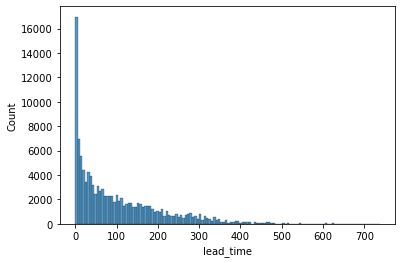

In [13]:
sns.histplot(df['lead_time'])

It is probably going to be difficult for the company to make decisions / plans about bookings that have a lead time of more than a year. 365 days should be a reasonable cutoff for our model. There is a long tail for lead time, as observable through the above graph

In [14]:
df[df.lead_time>365].count()

hotel                             3148
is_canceled                       3148
lead_time                         3148
arrival_date_month                3148
stays_in_weekend_nights           3148
stays_in_week_nights              3148
adults                            3148
children                          3148
babies                            3148
meal                              3148
market_segment                    3148
distribution_channel              3148
is_repeated_guest                 3148
previous_cancellations            3148
previous_bookings_not_canceled    3148
reserved_room_type                3148
assigned_room_type                3148
booking_changes                   3148
deposit_type                      3148
agent                             3148
days_in_waiting_list              3148
customer_type                     3148
adr                               3148
required_car_parking_spaces       3148
total_of_special_requests         3148
cancellation_rate        

3148 rows (around 2% of the total data) contain data for bookings that have a lead time of more than a year. I think it is safe to drop these rows.

In [15]:
df = df.drop(df[df.lead_time>365].index) # We drop the rows having lead time > 365 days

df_temp = df.select_dtypes(include=numerics)

pd.DataFrame(dict(mean = df_temp.mean().round(2),
                  median = df_temp.median().round(2),
                  std_dev = df_temp.std().round(2),
                  min_val = df_temp.min().round(2),
                  max_val = df_temp.max().round(2),
                  missing_vals = df_temp.isnull().sum()
                  ))

,mean,median,std_dev,min_val,max_val,missing_vals
is_canceled,0.36,0.0,0.48,0.00,1.0,0
lead_time,94.90,66.0,92.05,0.00,365.0,0
stays_in_weekend_nights,0.94,1.0,1.00,0.00,19.0,0
stays_in_week_nights,2.51,2.0,1.92,0.00,50.0,0
adults,1.86,2.0,0.58,0.00,55.0,0
children,0.11,0.0,0.40,0.00,10.0,0
babies,0.01,0.0,0.10,0.00,10.0,0
previous_cancellations,0.09,0.0,0.85,0.00,26.0,0
previous_bookings_not_canceled,0.14,0.0,1.52,0.00,72.0,0
booking_changes,0.22,0.0,0.66,0.00,21.0,0


<AxesSubplot:xlabel='adr', ylabel='Count'>

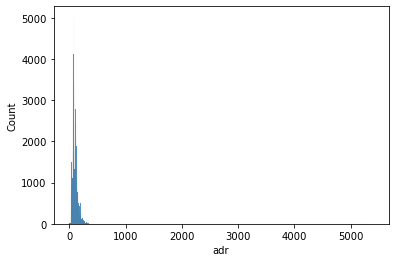

In [16]:
sns.histplot(df['adr'])

ADR ideally cannot be negative or zero. These likely indicate bookings that are made through a discount program or related. We would like to include only those bookings which are paid for (have an ADR > 0)

We also observe unrealistically high ADR values (such as >= 1000). We will remove these rows from our data as well.

In [17]:
df[df.adr>=1000].count()
df[df.adr<=0].count()

hotel                             1941
is_canceled                       1941
lead_time                         1941
arrival_date_month                1941
stays_in_weekend_nights           1941
stays_in_week_nights              1941
adults                            1941
children                          1941
babies                            1941
meal                              1941
market_segment                    1941
distribution_channel              1941
is_repeated_guest                 1941
previous_cancellations            1941
previous_bookings_not_canceled    1941
reserved_room_type                1941
assigned_room_type                1941
booking_changes                   1941
deposit_type                      1941
agent                             1941
days_in_waiting_list              1941
customer_type                     1941
adr                               1941
required_car_parking_spaces       1941
total_of_special_requests         1941
cancellation_rate        

1941 rows have ADR <= 0, and 1 row has ADR >= 1000. This is around 2% of our data. We will drop these rows

In [18]:
df = df.drop(df[df.adr<=0].index)
df = df.drop(df[df.adr>=1000].index)

df_temp = df.select_dtypes(include=numerics)

pd.DataFrame(dict(mean = df_temp.mean().round(2),
                  median = df_temp.median().round(2),
                  std_dev = df_temp.std().round(2),
                  min_val = df_temp.min().round(2),
                  max_val = df_temp.max().round(2),
                  missing_vals = df_temp.isnull().sum()
                  ))

,mean,median,std_dev,min_val,max_val,missing_vals
is_canceled,0.37,0.00,0.48,0.00,1.0,0
lead_time,95.91,67.00,92.05,0.00,365.0,0
stays_in_weekend_nights,0.95,1.00,1.00,0.00,19.0,0
stays_in_week_nights,2.54,2.00,1.91,0.00,50.0,0
adults,1.86,2.00,0.49,0.00,4.0,0
children,0.11,0.00,0.40,0.00,10.0,0
babies,0.01,0.00,0.10,0.00,10.0,0
previous_cancellations,0.09,0.00,0.86,0.00,26.0,0
previous_bookings_not_canceled,0.13,0.00,1.47,0.00,72.0,0
booking_changes,0.22,0.00,0.64,0.00,18.0,0


We have removed the outliers to some extent (have taken care of the unrealistic values, at least). We now continue with the analysis of the rest of the columns.

There are some columns that can be dropped - previous cancellations, previous_bookings_not_canceled (as we have created cancellation_rate which models both of them).

HOWEVER, to ensure 100% of the behaviour of previous cancellations and previous bookings not cancelled are present, I will create a column called "total bookings". This results in cancellation rate + total bookings giving us the full picture of previous cancellations and previous bookings not cancelled.

These columns required investigation - children, babies, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests. These columns seem to be sparsely filled as their mean values are very low.

In [19]:
df['total_bookings'] = df['previous_cancellations'] + df['previous_bookings_not_canceled']
df = df.drop(columns = ['previous_cancellations', 'previous_bookings_not_canceled'])

In [20]:
df['children'].unique()

df.children.value_counts() / len(df)

0     0.925713
1     0.042012
2     0.031610
3     0.000656
10    0.000009
Name: children, dtype: float64

92.5% of the data has the value of children as 0. This shows that children would not be able to explain is_canceled very well.

In [21]:
df['babies'].unique()

df.babies.value_counts() / len(df)

0     0.992213
1     0.007638
2     0.000131
10    0.000009
9     0.000009
Name: babies, dtype: float64

99% of the data has the value of babies as 0. Babies also will not be able to explain is_canceled very well.

In [22]:
df['days_in_waiting_list'].unique()

df.days_in_waiting_list.value_counts() / len(df)

0      0.969466
39     0.001627
58     0.001435
44     0.001234
31     0.001111
         ...   
116    0.000009
121    0.000009
142    0.000009
165    0.000009
36     0.000009
Name: days_in_waiting_list, Length: 124, dtype: float64

96.9% of the data has days in waiting list = 0. This column too would not be able to explain is_canceled very well.

In [23]:
df['required_car_parking_spaces'].unique()

df.required_car_parking_spaces.value_counts() / len(df)

0    0.936212
1    0.063508
2    0.000236
3    0.000026
8    0.000017
Name: required_car_parking_spaces, dtype: float64

93.6% of the data has required car parking spaces as 0. We will keep this however, as it may occur that the lack of a parking space results in a cancellation of the booking.

In [24]:
df['total_of_special_requests'].unique()

df.total_of_special_requests.value_counts() / len(df)

0    0.583281
1    0.281137
2    0.111172
3    0.021225
4    0.002835
5    0.000350
Name: total_of_special_requests, dtype: float64

58.3% of the data has total number of special requests as 0. There is more variation in this column versus the other columns that were just analyzed. We will keep this column.

In [25]:
df['total_children'] = df['children'] + df['babies']
df = df.drop(columns=['children', 'babies', 'days_in_waiting_list'])

We create a new column 'total children', that would combine the children and babies column to effectively reduce the number of '0' values. Total Children can be a useful variable, as in case there is no extra bed / other ameneties available for children, the booking may get canceled

><h3>Correlation Matrix</h3>
Now that our (numeric) data is ready, we can start to generate and look at the correlation matrix. From this we can understand which are those independent variables that seem to influence MSRP the most.

In [26]:
df.corr()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,booking_changes,adr,required_car_parking_spaces,total_of_special_requests,cancellation_rate,total_bookings,total_children
is_canceled,1.000000,0.279599,0.004100,0.025766,0.054519,-0.139408,0.048788,-0.196576,-0.225245,0.295108,0.009117,0.001371
lead_time,0.279599,1.000000,0.133335,0.217441,0.135369,0.014956,-0.053525,-0.114930,-0.068481,0.272865,-0.008920,-0.022899
stays_in_weekend_nights,0.004100,0.133335,1.000000,0.495139,0.105835,0.047228,0.028362,-0.021818,0.069529,-0.051005,-0.038678,0.046970
stays_in_week_nights,0.025766,0.217441,0.495139,1.000000,0.106932,0.076558,0.046947,-0.027989,0.069034,-0.051973,-0.044600,0.045943
adults,0.054519,0.135369,0.105835,0.106932,1.000000,-0.046297,0.289553,0.018639,0.154000,-0.010707,-0.105735,0.040064
booking_changes,-0.139408,0.014956,0.047228,0.076558,-0.046297,1.000000,0.035411,0.068365,0.054150,-0.067431,-0.003245,0.070237
adr,0.048788,-0.053525,0.028362,0.046947,0.289553,0.035411,1.000000,0.058800,0.182646,-0.126010,-0.087435,0.348583
required_car_parking_spaces,-0.196576,-0.114930,-0.021818,-0.027989,0.018639,0.068365,0.058800,1.000000,0.079223,-0.056710,0.031611,0.061565
total_of_special_requests,-0.225245,-0.068481,0.069529,0.069034,0.154000,0.054150,0.182646,0.079223,1.000000,-0.127662,-0.005725,0.099511
cancellation_rate,0.295108,0.272865,-0.051005,-0.051973,-0.010707,-0.067431,-0.126010,-0.056710,-0.127662,1.000000,0.195942,-0.055238


Lead time and cancellation rate have the highest positive correlation (28%, 30%) with is_canceled. Total number of special requests has a negative correlation (-23%). The rest of the variables do not show much of a correlation.

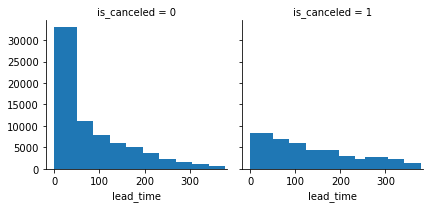

In [27]:
grid = sns.FacetGrid(df, col='is_canceled')
grid.map(plt.hist, 'lead_time', width=50)
grid.add_legend()

It appears that most bookings that are made at the hotel (lead time = 0) are not cancelled. 

In [28]:
df_group = df_temp.groupby(by='is_canceled').cancellation_rate.agg(['mean']).round(2)
display(df_group)

,mean
is_canceled,
0,0.00
1,0.13


When we look at the mean of cancellation rate vs. the is_canceled field, we can see that it indicates a relationship. 13% is the mean where bookings were canceled (is_canceled=1), whereas the mean is 0% for not canceled (is_canceled = 0)

In [29]:
df_group = df_temp.groupby(by='is_canceled').adr.agg(['mean']).round(2)
display(df_group)

,mean
is_canceled,
0,102.40
1,107.16


ADR shows almost no variation between is_canceled 0 and 1

><h3>Data Deep Dive - Categorical</h3>
For categorical variables, the first thing we want to understand is - what are the unique values for each categorical column? This will help to explain each column to understand it's effect on the target variable. Once this is complete, we can begin to summarize the target variable as a function of each unique value in the categorical column/s. If we observe that there is not much variance in the target variable (mean) between unique values of the categorical column, we may then choose to drop the column as it is not beneficial. We then convert the categorical variables to numerical indicators through a process known as "one-hot encoding". We ensure to drop those columns that are not beneficial in predicting / influencing the target variable value.

In [30]:
# We now focus solely on the categorical columns.
categorical = ['object']

df_temp = pd.merge(df['is_canceled'],df.select_dtypes(include=categorical),left_index=True,right_index=True)

df_temp.head()
# To verify that we have all the categorical variables that we expect

,is_canceled,hotel,arrival_date_month,meal,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,agent,customer_type
2,0,Resort Hotel,July,BB,Direct,Direct,0,A,C,No Deposit,0,Transient
3,0,Resort Hotel,July,BB,Corporate,Corporate,0,A,A,No Deposit,304,Transient
4,0,Resort Hotel,July,BB,Online TA,TA/TO,0,A,A,No Deposit,240,Transient
5,0,Resort Hotel,July,BB,Online TA,TA/TO,0,A,A,No Deposit,240,Transient
6,0,Resort Hotel,July,BB,Direct,Direct,0,C,C,No Deposit,0,Transient


#### Observations:

- There seem to be many unique values for the 'agent' column, will need to check it and reduce the levels if needed.

In [31]:
df_temp['agent'].unique()

df.agent.value_counts() / len(df)

9      0.278670
0      0.133377
240    0.120577
1      0.050271
14     0.031680
         ...   
285    0.000009
289    0.000009
93     0.000009
265    0.000009
59     0.000009
Name: agent, Length: 333, dtype: float64

The top 5 agents contribute to 61% of bookings. We can keep the top 5 and combine the others into a separate category called "others"

In [32]:
agent_other_list = np.setdiff1d(df.agent.unique(),[9,0,240,1,14])

df['agent'] = df['agent'].replace(agent_other_list, 'Other')

df['agent'].unique()

array([0, 'Other', 240, 9, 1, 14], dtype=object)

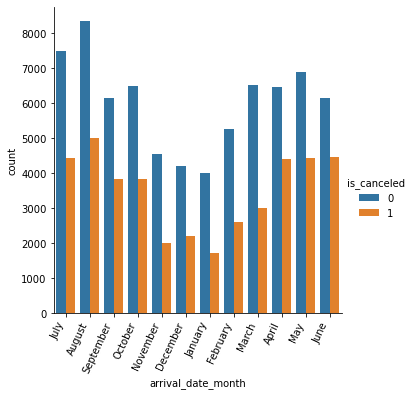

In [33]:
chart = sns.catplot(data=df, x='arrival_date_month', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

There are fewer bookings made between November and January versus other months. The count of is_canceled = 1 and 0 remains relatively the same.

In [34]:
df_temp['meal'].unique()

df.meal.value_counts() / len(df)

BB           0.772712
HB           0.119239
SC           0.091312
Undefined    0.009895
FB           0.006842
Name: meal, dtype: float64

In [35]:
df['meal'] = df['meal'].replace('Undefined', 'SC')

Undefined can be changed to "SC", as both indicate no meal.

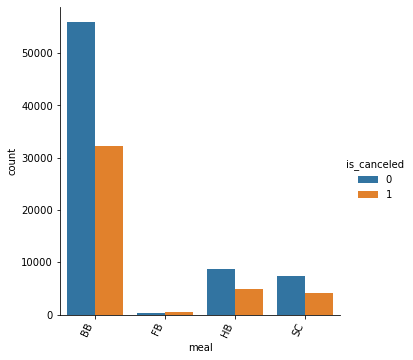

In [36]:
chart = sns.catplot(data=df, x='meal', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

There does not seem to be much variation between each meal type. While the BB meal has the highest number of bookings (counts are high), the number of is_canceled = 1 vs. is_canceled = 0 is relatively the same (the ratio) across all meal types. This may indicate that it is not a strong variable to determine is_canceled.

In [37]:
df_temp['market_segment'].unique()

df.market_segment.value_counts() / len(df)

Online TA        0.490761
Offline TA/TO    0.200140
Groups           0.152756
Direct           0.108154
Corporate        0.045608
Aviation         0.002021
Complementary    0.000542
Undefined        0.000017
Name: market_segment, dtype: float64

99% of the data is explained by the first 5 categories. We will group the rest into "Other"

In [38]:
df['market_segment'] = df['market_segment'].replace(['Aviation', 'Complementary', 'Undefined'], 'Other')

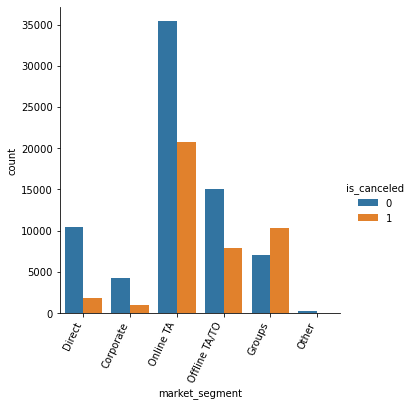

In [39]:
chart = sns.catplot(data=df, x='market_segment', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

We notice that there is a variation in the counts of is_canceled = 1 between various market segments. Direct shows low is_canceled = 1, whereas Groups has is_canceled = 1 counts higher than is_canceled = 0.

In [40]:
df_temp['distribution_channel'].unique()

df.distribution_channel.value_counts() / len(df)

TA/TO        0.821374
Direct       0.120849
Corporate    0.056080
GDS          0.001654
Undefined    0.000044
Name: distribution_channel, dtype: float64

99% of the data is explained by the first 3 categories. We will group the rest into "Other"

In [41]:
df['distribution_channel'] = df['distribution_channel'].replace(['GDS', 'Undefined'], 'Other')

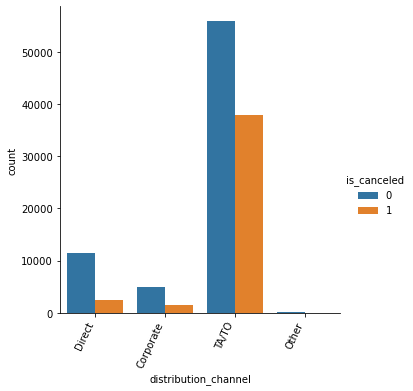

In [42]:
chart = sns.catplot(data=df, x='distribution_channel', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

While there is some variation observed, it seems that the distribution_channel column follows a similar pattern versus the market segment column (the values are similar). The market segment column is a better one to use as it has more unique values, and the degree of variation is higher.

In [43]:
df_temp['reserved_room_type'].unique()

df.reserved_room_type.value_counts() / len(df)

A    0.713088
D    0.166150
E    0.055809
F    0.024698
G    0.017550
B    0.009475
C    0.007970
H    0.005206
L    0.000052
Name: reserved_room_type, dtype: float64

98% of reserved room types are explained by the first 5 categories. We will group the rest into "Other"

In [44]:
df['reserved_room_type'] = df['reserved_room_type'].replace(['B', 'C', 'H', 'L'], 'Other')

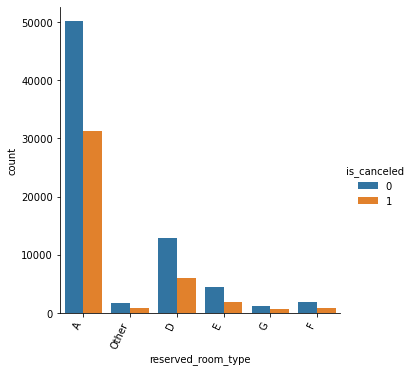

In [45]:
chart = sns.catplot(data=df, x='reserved_room_type', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

There does not seem to be much variation between various reserved room types. This is expected as the customers have made the choice on their preferred room and this preferred / reserved room type is unlikely to have any effect on their decision to cancel the booking.

In [46]:
df_temp['assigned_room_type'].unique()

df.assigned_room_type.value_counts() / len(df)

A    0.614733
D    0.218250
E    0.066693
F    0.031864
G    0.021461
C    0.020192
B    0.017988
H    0.006124
I    0.001400
K    0.001286
L    0.000009
Name: assigned_room_type, dtype: float64

99% of assigned room types are explained by the first 6 categories. We will group the rest into "Other"

In [47]:
df['assigned_room_type'] = df['assigned_room_type'].replace(['B','H','I','K','L'], 'Other')

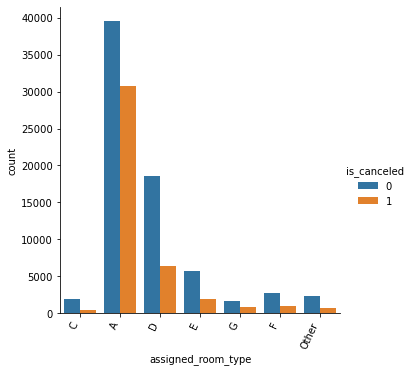

In [48]:
chart = sns.catplot(data=df, x='assigned_room_type', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

There is some variation observable here. We do see that the assigned room type A has a much higher count of is_canceled = 1 versus other assigned room types.

Based on the analyses above, we drop these columns - reserved_room_type, distribution_channel, meal. These will be dropped in the feature engineering section below.

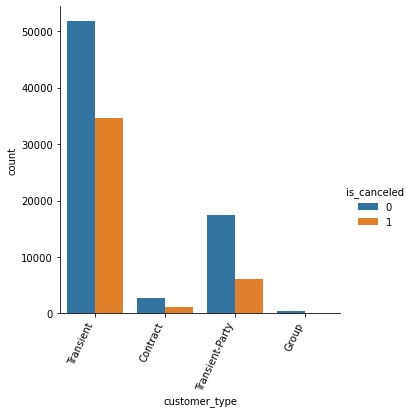

In [49]:
chart = sns.catplot(data=df, x='customer_type', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

There is some variance observable in customer_type. The Transient customer type seems to have more is_canceled = 1 entries versus others.

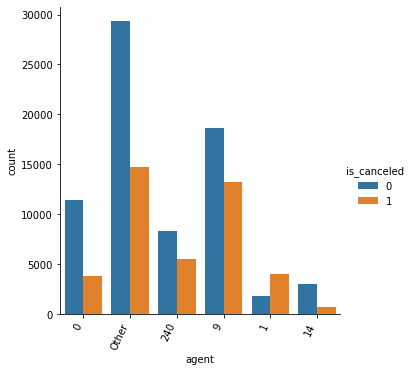

In [50]:
chart = sns.catplot(data=df, x='agent', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

There is variance observable in the agent column. Agent 1 also shows more is_canceled = 1 entries than is_canceled = 0.

><h3>Feature Engineering</h3>
We create some custom features that would be useful for the prediction of is_canceled. These features are representations of existing variables. We also update the values of the month column to reflect "month number" rather than "month name"

In [51]:
def roomChange(row):
    if row['assigned_room_type'] == row['reserved_room_type']:
        return 0
    else:
        return 1

df['change_in_room'] = df.apply(roomChange, axis=1)
df['change_in_room'] = df['change_in_room'].astype("object")

One potential cause for customer dissatisfaction (that could lead to cancelation) is when the actual (assigned) room is different versus the preferred (reserved) room. We model this using a new variable - "change in room", which is 1 is the room is different, and 0 if the room is the same.

This also represents some part of reserved room type (when combined with assigned room type).

In [52]:
df = df.drop(columns = ['reserved_room_type', 'distribution_channel', 'meal'])

# Data Preparation

Now that we have completed the Exploratory Data Analysis and have prepared the columns in the data to be ready for modeling - we can now begin to set up the features and target variable for inclusion in the model function.

In [53]:
df_original = df

cat_vars = df.select_dtypes(include=categorical).columns

for var in cat_vars:
    df[var] = df[var].astype("category")

df = pd.get_dummies(df,columns=cat_vars, prefix_sep='_', drop_first=True)

We select only the categorical variables for preparation of dummy columns. N-1 dummy columns are created (by using drop_first = True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114300 entries, 2 to 119389
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   is_canceled                    114300 non-null  int64  
 1   lead_time                      114300 non-null  int64  
 2   stays_in_weekend_nights        114300 non-null  int64  
 3   stays_in_week_nights           114300 non-null  int64  
 4   adults                         114300 non-null  int64  
 5   booking_changes                114300 non-null  int64  
 6   adr                            114300 non-null  float64
 7   required_car_parking_spaces    114300 non-null  int64  
 8   total_of_special_requests      114300 non-null  int64  
 9   cancellation_rate              114300 non-null  float64
 10  total_bookings                 114300 non-null  int64  
 11  total_children                 114300 non-null  int64  
 12  hotel_Resort Hotel            

All dummy columns were successfully created, and our final dataset is ready for splitting into test and train.

><h3>Selection of Train & Test data</h3>
Now that we have completed all of the aforementioned steps, we can create the testing and training dataset by choosing a random sample of 70% of the data for training purposes, while the remaining 30% is used for testing the model output to determine accuracy.

In [55]:
predictors = df.columns.drop('is_canceled')

# We have split the predictors and target variable (above and below are just lists that contain their names)

target = ['is_canceled']

X = df[predictors]
y = df[target]

# We have X, which is our set of independent variables. Y is our target variable

X_train_encoded,X_test_encoded,y_train_encoded,y_test_encoded = train_test_split(X,y, test_size=0.3,random_state=2)

predictors = df_original.columns.drop('is_canceled')

X = df_original[predictors]
y = df_original[target]

X_train_original,X_test_original,y_train_original,y_test_original = train_test_split(X,y, test_size=0.3,random_state=2)

We create 2 versions of our training data. One version (_ encoded) contains the numerical variables + encoded categorical variables. The other version (_ original) contains the numerical variables + original categorical variables. This is just so that we have options of data that we can use for each of our 5 models.

In [56]:
# Normalize predictor variables using Z-Scores.
# Use means and standard deviations of features as calculated in the TRAINING DATA
# New values are centered at 0.  Values reflect the number of standard deviations
# each record is above or below the mean.

# Note - this is done only for numeric variables. Hence, we first separate categorical and numeric before we normalize.
#X_train_original = X_train
#X_test_original = X_test

X_train_dummy_encoded = X_train_encoded.iloc[:,15:]
X_train_dummy_original = X_train_original.iloc[:,15:]
X_train = X_train_encoded.iloc[:,0:14]

X_test_dummy_encoded = X_test_encoded.iloc[:,15:]
X_test_dummy_original = X_test_original.iloc[:,15:]
X_test = X_test_encoded.iloc[:,0:14]

features_means = X_train.mean()
features_std = X_train.std()

X_train_norm = (X_train - features_means)/features_std
X_test_norm = (X_test - features_means)/features_std

X_train_encoded_norm = pd.concat([X_train_norm, X_train_dummy_encoded], axis=1)
X_test_encoded_norm = pd.concat([X_test_norm, X_test_dummy_encoded], axis=1)

X_train_encoded = pd.concat([X_train, X_train_dummy_encoded], axis=1)
X_test_encoded = pd.concat([X_test, X_test_dummy_encoded], axis=1)

X_train_original = pd.concat([X_train, X_train_dummy_original], axis=1)
X_test_original = pd.concat([X_test, X_test_dummy_original], axis=1)

We normalize our data (the numerical variables). First, we split the categorical and numeric data. 

Next, we find the mean and standard deviation of our training data.

Finally, we create the new training data. We create different versions (normalized numeric + encoded categorical, original numeric + encoded categorical, original numeric + original categorical) of the training data so that we can use it (as required) in each of our 5 models

# Model Building & Evaluation

Now that our split (train / test) data is ready, we can start to build our linear regression models

><h3>Logistic Regression  </h3>
We implement a logistic regression model, while utilizing GridSearchCV to find the optimal hyperparameters

In [57]:
st = time.time() # To record start time

In [58]:
param_grid = {
    'C': np.logspace(-3,3,7), 
    'penalty': ['none','l2']
}

We initialize a grid of parameters which will be used by GridSearchCV to finetune the hyperparameters of LogisticRegression. The parameters we tune are C and the penalty.

In [59]:
gridSearch = GridSearchCV(LogisticRegression(max_iter=500), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1,  #used to marshall all available CPUs
                          verbose=4
                         )

gridSearch.fit(X_train_encoded_norm,y_train_encoded.values.ravel())

print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Initial score:  0.816960379952506
Initial parameters:  {'C': 0.01, 'penalty': 'l2'}


GridSearchCV finds the optimal combination of hyperparameters that gives the best score. This is the ideal model and we use this when comparing with models created through other algorithms

In [60]:
bestLRModel = gridSearch.best_estimator_

y_train_pred_class = bestLRModel.predict(X_train_encoded_norm)
y_test_pred_class = bestLRModel.predict(X_test_encoded_norm)

print('Training data Accuracy:', metrics.accuracy_score(y_train_encoded,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test_encoded,y_test_pred_class).round(2))

Training data Accuracy: 0.82
Testing data Accuracy: 0.82


There is no evidence of overfitting as the train and test accuracy are the same (82%)

In [61]:
et = time.time()
runtime = et-st
print(runtime)

67.3503053188324


It took around 67 seconds to run the Logistic Regression model.

> **kNN** <a class="anchor" id="first-model"></a>
<br>
>Steps to Complete:<br>
>1. Fit numerous kNN models using different values for k. <br>
>2. Choose the "best" value for "k" based on Accuracy
>3. Ensure a k value that is not too low (leads to overfitting) and not too high (leads to underfitting)

In [62]:
#k_range = list(range(1, 22, 2))
#param_grid = dict(n_neighbors=k_range)

In [63]:
#gridSearch = GridSearchCV(KNeighborsClassifier(), 
#                          param_grid, 
#                          cv=5,
#                          n_jobs=-1  #used to marshall all available CPUs
#                         )
#gridSearch.fit(X_train_encoded_norm,y_train_encoded.values.ravel())

#print('Initial score: ', gridSearch.best_score_)
#print('Initial parameters: ', gridSearch.best_params_)

Above is a potential implementation of GridSearchCV for KNN. This is computationally intensive and was not feasible to run on my system, hence I am going with the conventional approach of determining the ideal k

In [64]:
st = time.time() # We record the start time

In [65]:
# 1. train a classifier for different values of k
results = []
for k in [1,3,5,7,9,11,13,15,17,19,21]:
    #print(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_encoded_norm,y_train_encoded.values.ravel())
    
    # Get predicted class
    y_pred_class = knn.predict(X_test_encoded_norm)
    
    # Put Accuracy Score in results object
    results.append({'k':k,
                    'accuracy':metrics.accuracy_score(y_test_encoded,y_pred_class)
                   }
                  )
# Put results from above into a Pandas Dataframe
results_df = pd.DataFrame(results)
results_df

,k,accuracy
0,1,0.813036
1,3,0.819889
2,5,0.823768
3,7,0.824293
4,9,0.825868
5,11,0.824789
6,13,0.824643
7,15,0.823797
8,17,0.822776
9,19,0.822310


>**Decision:**<br>
Based on the results above, I will set my number of neighbors (k) to 7 as this is the lowest value of k that achieves the highest accuracy value (82%). I do not choose higher values of k even though they have higher accuracy as this may lead to issues with the model performance <br>

>**Re-run kNN using the value selected above:**<br>
This final run of kNN will be used when comparing with models from other algorithms

In [66]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_encoded_norm,y_train_encoded.values.ravel())

# Let's do a quick check to see if we have to worry about problems of overfitting.
# Remember!  Small values for "k" in kNN tend to lead to overfitting.
# Large value for "k" in kNN tend to produce underfit models
y_train_pred_class = knn.predict(X_train_encoded_norm)
y_test_pred_class = knn.predict(X_test_encoded_norm)

print('Training data Accuracy:', metrics.accuracy_score(y_train_encoded,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test_encoded,y_test_pred_class).round(2))

Training data Accuracy: 0.87
Testing data Accuracy: 0.82


There is no major evidence of overfitting as the train and test accuracy are relatively similar (87% vs. 82%)

In [67]:
et = time.time()
runtime = et-st
print(runtime)

996.7300174236298


It took around 997 seconds to run this model

> **Decision Tree** <a class="anchor" id="first-model"></a>
<br>
>Steps to Complete:<br>
>1. Set up the grid of parameters that will be used by GridSearchCV to find the optimal hyperparameters for Decision Tree <br>
>2. Obtain the best Decision Tree model from GridSearchCV
>3. Check test and train accuracy to verify to overfitting / underfitting problems

In [68]:
st = time.time() # We record the start time

In [69]:
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01]
}

We initialize a grid of parameter values that will be used by GridSearchCV to find the optimal hyperparameter values. The parameters we are focusing on for Decision Tree are max_depth, min_samples_split and min_impurity_decrease. The optimal values of these parameters will help to ensure that the tree is pruned in an ideal manner.

In [70]:
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1  #used to marshall all available CPUs
                         )
gridSearch.fit(X_train_encoded,y_train_encoded.values.ravel())

print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.8299712535933008
Initial parameters:  {'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 60}


In [71]:
# Adapt grid based on findings in last cell
param_grid = {
    'max_depth': [16, 18, 20, 22, 24],
    'min_samples_split': [90, 100, 110, 120],
    'min_impurity_decrease': [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
}

Based on the initial parameters we have obtained earlier, we update our grid of parameters to reflect a range of values that are in a range above and below the initial parameter values. This will help to confirm that we indeed have the parameter values (and that the intial parameters were not a local optima)

In [72]:
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1  #used to marshall all available CPUs
                         )
gridSearch.fit(X_train_encoded,y_train_encoded.values.ravel())

print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

Improved score:  0.8315710536182976
Improved parameters:  {'max_depth': 20, 'min_impurity_decrease': 0.0001, 'min_samples_split': 90}


In [73]:
bestClassTree = gridSearch.best_estimator_

y_train_pred_class = bestClassTree.predict(X_train_encoded)
y_test_pred_class = bestClassTree.predict(X_test_encoded)

print('Training data Accuracy:', metrics.accuracy_score(y_train_encoded,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test_encoded,y_test_pred_class).round(2))

Training data Accuracy: 0.84
Testing data Accuracy: 0.83


There is no evidence of overfitting as the train and test accuracy are similar (84% vs. 83%)

In [74]:
et = time.time()
runtime = et-st
print(runtime)

191.99890303611755


It took around 192 seconds to run this model.

> **Random Forest** <a class="anchor" id="first-model"></a>
<br>
>Steps to Complete:<br>
>1. Set up a grid of parameters that will be used by GridSearchCV to find the optimal hyperparameters for the Random Forest model <br>
>2. Obtain the best Random Forest model from GridSearchCV
>3. Check test and train accuracy to verify no overfitting or underfitting problems.

In [75]:
st = time.time() # We record the start time

In [76]:
param_grid = {
    'max_features': ['auto'],
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

We initialize a grid of parameter values that will be used by GridSearchCV to find the optimal hyperparameter values. The parameters we are focusing on for Random Forest are max_depth and number of estimators.

In [77]:
gridSearch = GridSearchCV(RandomForestClassifier(random_state=1), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1,  #used to marshall all available CPUs
                          verbose=4
                         )

gridSearch.fit(X_train_encoded,y_train_encoded.values.ravel())

print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Initial score:  0.8612798400199975
Initial parameters:  {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 300}


In [78]:
bestRandomTree = gridSearch.best_estimator_

y_train_pred_class = bestRandomTree.predict(X_train_encoded)
y_test_pred_class = bestRandomTree.predict(X_test_encoded)

print('Training data Accuracy:', metrics.accuracy_score(y_train_encoded,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test_encoded,y_test_pred_class).round(2))

Training data Accuracy: 0.97
Testing data Accuracy: 0.87


There is evidence of overfitting as the train accuracy is 10% higher than the test accuracy (97% vs. 87%)

In [79]:
et = time.time()
runtime = et-st
print(runtime)

365.57771492004395


This model took around 365 seconds to run

> **Artificial Neural Network** <a class="anchor" id="first-model"></a>
<br>
>Steps to Complete:<br>
>1. Set up a grid of parameters that will be used by GridSearchCV to find the optimal hyperparameters for the MLP Classifier <br>
>2. Obtain the best MLP Classifier model from GridSearchCV
>3. Check test and train accuracy to verify no overfitting or underfitting problems.

In [80]:
st = time.time() # We record the start time

In [81]:
param_grid = {
    'hidden_layer_sizes': [(20,20), (20,20,20)],
    'activation': ['tanh'],
    'alpha': [0.0001,0.001]
}

We initialize a grid of parameter values that will be used by GridSearchCV to find the optimal hyperparameter values. The parameters we are focusing on for the MLP Classifier are the size (and count) of hidden layers and the alpha value.

In [82]:
gridSearch = GridSearchCV(MLPClassifier(max_iter=500), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1,  #used to marshall all available CPUs
                          verbose=4
                         )

gridSearch.fit(X_train_encoded_norm,y_train_encoded.values.ravel())

print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Improved score:  0.8349331333583303
Improved parameters:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (20, 20)}


In [83]:
bestMLPClassifier = gridSearch.best_estimator_

y_pred_prob = bestMLPClassifier.predict_proba(X_test_encoded_norm)[:,1]
y_pred_prob_train = bestMLPClassifier.predict_proba(X_train_encoded_norm)[:,1]
y_pred_class = binarize([y_pred_prob],threshold=0.5)[0]
y_pred_class_train = binarize([y_pred_prob_train],threshold=0.5)[0]
confusion_test=confusion_matrix(y_test_encoded,y_pred_class)
confusion_train=confusion_matrix(y_train_encoded,y_pred_class_train)

print('Train Accuracy: ',metrics.accuracy_score(y_train_encoded,y_pred_class_train).round(2))
print('Test Accuracy: ',metrics.accuracy_score(y_test_encoded,y_pred_class).round(2))
print('Train F1: ',metrics.f1_score(y_train_encoded,y_pred_class_train).round(2))
print('Test F1: ', metrics.f1_score(y_test_encoded,y_pred_class).round(2))

Train Accuracy:  0.85
Test Accuracy:  0.84
Train F1:  0.78
Test F1:  0.77


There is no evidence of overfitting as the train and test accuracy values are similar (85% vs. 84%)

In [84]:
et = time.time()
runtime = et-st
print(runtime)

1064.010610818863


This model took around 1064 seconds to run

# Model Results Evaluation

Now that we have our final 5 model objects, we can evaluate their performance in detail to choose a winning model. This winning model will be analyzed further to understand the optimal probability threshold that can be set.

In [85]:
bestLRModel # Logistic Regression
knn # KNN
bestClassTree # Decision Tree
bestRandomTree # Random Forest
bestMLPClassifier # MLP Classifier

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(20, 20),
              max_iter=500)

> **Choosing best model** <a class="anchor" id="first-model"></a>
<br>
>Steps to Complete:<br>
>1. Plot ROC Curve for each of the 5 models <br>
>2. Choose the best model based on which has the highest AUC score.

C:\Users\theda\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\theda\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\theda\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be remov

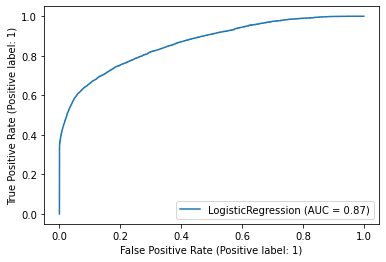

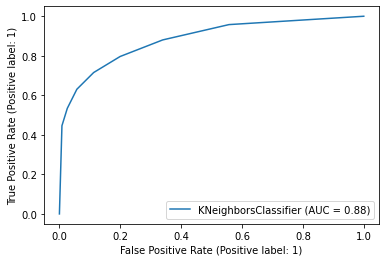

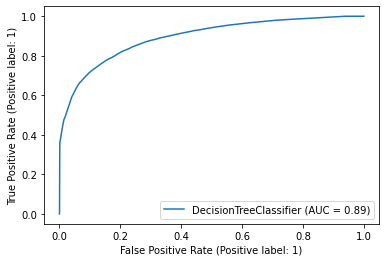

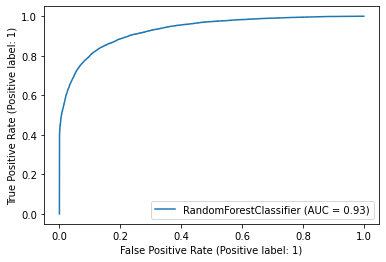

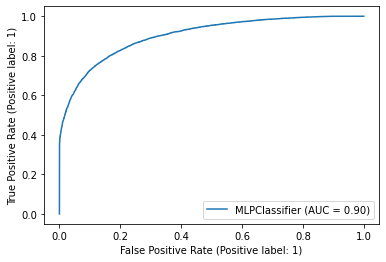

In [86]:
metrics.plot_roc_curve(bestLRModel,X_test_encoded_norm,y_test_encoded)
metrics.plot_roc_curve(knn,X_test_encoded_norm,y_test_encoded)
metrics.plot_roc_curve(bestClassTree,X_test_encoded,y_test_encoded)
metrics.plot_roc_curve(bestRandomTree,X_test_encoded,y_test_encoded)
metrics.plot_roc_curve(bestMLPClassifier,X_test_encoded_norm,y_test_encoded)

Based on the AUC scores, we can conclude that the Random Forest model is the best (AUC = 0.93). However, it is also overfitting as evident in the train vs. test accuracy scores. 

Hence, we will select the MLPClassifier as the winning model (AUC = 0.90, which is the next highest), and will investigate its probability thresholds further.

> **Choosing best probability threshold** <a class="anchor" id="first-model"></a>
<br>
>Steps to Complete:<br>
>1. Obtain the performance measures (precision, recall, accuracy, etc) for various probability thresholds <br>
>2. Choose the "best" probability threshold that maximizes business benefit

In [87]:
class_perf_measures(bestMLPClassifier,X_test_encoded_norm,y_test_encoded)

C:\Users\theda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,Precision,Recall,F1,Accuracy
0,0.0,12582,0,21708,0,0.367,1.000,0.54,0.37
1,0.1,12097,10042,11666,485,0.509,0.961,0.67,0.65
2,0.2,11488,13876,7832,1094,0.595,0.913,0.72,0.74
3,0.3,10801,16479,5229,1781,0.674,0.858,0.75,0.80
4,0.4,10012,18194,3514,2570,0.740,0.796,0.77,0.82
5,0.5,9272,19363,2345,3310,0.798,0.737,0.77,0.84
6,0.6,8555,20087,1621,4027,0.841,0.680,0.75,0.84
7,0.7,7559,20777,931,5023,0.890,0.601,0.72,0.83
8,0.8,6336,21310,398,6246,0.941,0.504,0.66,0.81
9,0.9,5179,21610,98,7403,0.981,0.412,0.58,0.78


In this scenario, false negatives would be problematic for the business. This is because if we say that a customer will cancel a booking but they don't, it's acceptable. However, if we say that the customer will not cancel a booking but they do, it causes risk and potential loss of revenue due to the misclassified prediction.

The best probability threshold seems to be 0.3, as it results in a Recall of 0.858 (1781 False Negatives), with an accuracy of 0.80 (that is still somewhat close to the best accuracy). This threshold will ensure that we have an accurate model that also focuses on reducing false negatives, thereby bringing benefits to the business.

**Minimum Required Data**

The attributes that we will need for this model to perform optimally are:

- Lead Time, Stay in Weekend Night, Stay in Week Night, # Adults, # Total Children, Total Bookings, Previous Cancellations (to calculate Cancellation Rate), ADR, # of Parking, # of Special Requests, # of Booking Changes


- Arrival Month, Assigned Room Type, Reserved Room Type (to calculate change in room status), Deposit Type, Agent, Customer Type

**Run Time**

The model took 1064 seconds (around 18 minutes) to run from start to finish.


It is difficult to obtain the feature importances through the MLPClassifier, however we could improve the accuracy of the random forest model (to eliminate overfitting) and obtain the feature importances through it.

# Recommendations

Our recommendations to the business

- Using this model, I would recommend first beginning with a validation exercise to ensure that the model output conforms to what is actually happening on the ground. This validation exercise will ensure that all stakeholders are convinced of the performance of this model.


- The business should test the model for some hotel locations so that they can start to build on their strategy of how they can monetize the rooms that are likely to get canceled. Such an exercise will not only help to bring in more revenue, but will also help in improving model performance further.


- In terms of data, it would be useful to retrieve a few more data points (if available):
    - Rewards Member (is the customer a member of the rewards program?)
    - First Booking Date (the date the customer first made a booking with the hotel, to understand loyalty)
    - Customer Lifetime Value (a total sum of the amount that the customer has spent for their stay, in hotel purchases (food / bev), etc.)